#### Import all the python libraries

In [1]:
import warnings
# Set to ignore any warnings
warnings.filterwarnings('ignore')

In [2]:
#import libraries
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

from sklearn.preprocessing import StandardScaler

#### Read the solar wind data at 1~au 

In [3]:
df = pd.read_csv('Data_collection/Data/1992-2023.csv1', skiprows=None)#, header=True)

In [4]:
df.columns = ['date','B','T[K]','Np','Ur']

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.set_index(df['date'],inplace = True)

In [7]:
sw = df.drop(columns = ['date'])

In [8]:
sw.head(3)

,B,T[K],Np,Ur
date,,,,
1992-01-01 00:30:00+00:00,999.9,10000000.0,999.9,9999.0
1992-01-01 01:30:00+00:00,999.9,10000000.0,999.9,9999.0
1992-01-01 02:30:00+00:00,999.9,10000000.0,999.9,9999.0


In [9]:
sw  = sw.resample('3H').mean()

In [10]:
sw.head(8)

,B,T[K],Np,Ur
date,,,,
1992-01-01 00:00:00+00:00,999.900000,10000000.0,999.9,9999.0
1992-01-01 03:00:00+00:00,999.900000,10000000.0,999.9,9999.0
1992-01-01 06:00:00+00:00,999.900000,10000000.0,999.9,9999.0
1992-01-01 09:00:00+00:00,999.900000,10000000.0,999.9,9999.0
1992-01-01 12:00:00+00:00,10.833333,10000000.0,999.9,9999.0
1992-01-01 15:00:00+00:00,340.100000,10000000.0,999.9,9999.0
1992-01-01 18:00:00+00:00,999.900000,10000000.0,999.9,9999.0
1992-01-01 21:00:00+00:00,999.900000,10000000.0,999.9,9999.0


#### Check for nulls

In [11]:
sw.isna().sum()

B       0
T[K]    0
Np      0
Ur      0
dtype: int64

#### Check for unique values

In [12]:
### Minimum solar wind speed observed
np.min(sw['Ur'].unique())

237.33333333333334

In [13]:
### Maximum solar wind speed observed
np.max(sw['Ur'].unique())

9999.0

In [14]:
### Replace the max wind speed or 9999.0 as nan
#sw['Ur'] = sw['Ur'].replace(np.nan, 9999.0)  

In [15]:
### Categorize the wind speed into slow, and fast solar wind speed
sw.loc[(sw['Ur'] > 200.0) & (sw['Ur'] < 450.0), 'Wind_Category'] = 'Slow'
sw.loc[(sw['Ur'] >=450) & (sw['Ur'] < 850.0), 'Wind_Category'] = 'Fast'
sw.loc[sw['Ur'] >= 850, 'Wind_Category'] = 'extreme'

##### Pie chart for the solar wind distribution from year 1992 to 2022 december

In [16]:
sw['Wind_Category'].value_counts()

Wind_Category
Slow       55891
Fast       28129
extreme     6564
Name: count, dtype: int64

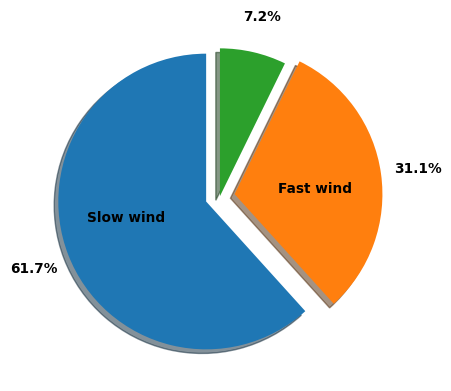

In [17]:
fig, ax = plt.subplots()

explode = (0.1, 0.1, 0)
labels = 'Slow wind', 'Fast wind', '',

ax.pie(sw['Wind_Category'].value_counts(dropna = False),explode = explode, 
       labels=labels,autopct='%1.1f%%',labeldistance=0.3,pctdistance=1.25, shadow= True, startangle=90,
      textprops={'size': 9.8,'fontweight' : 'bold'})


plt.show()

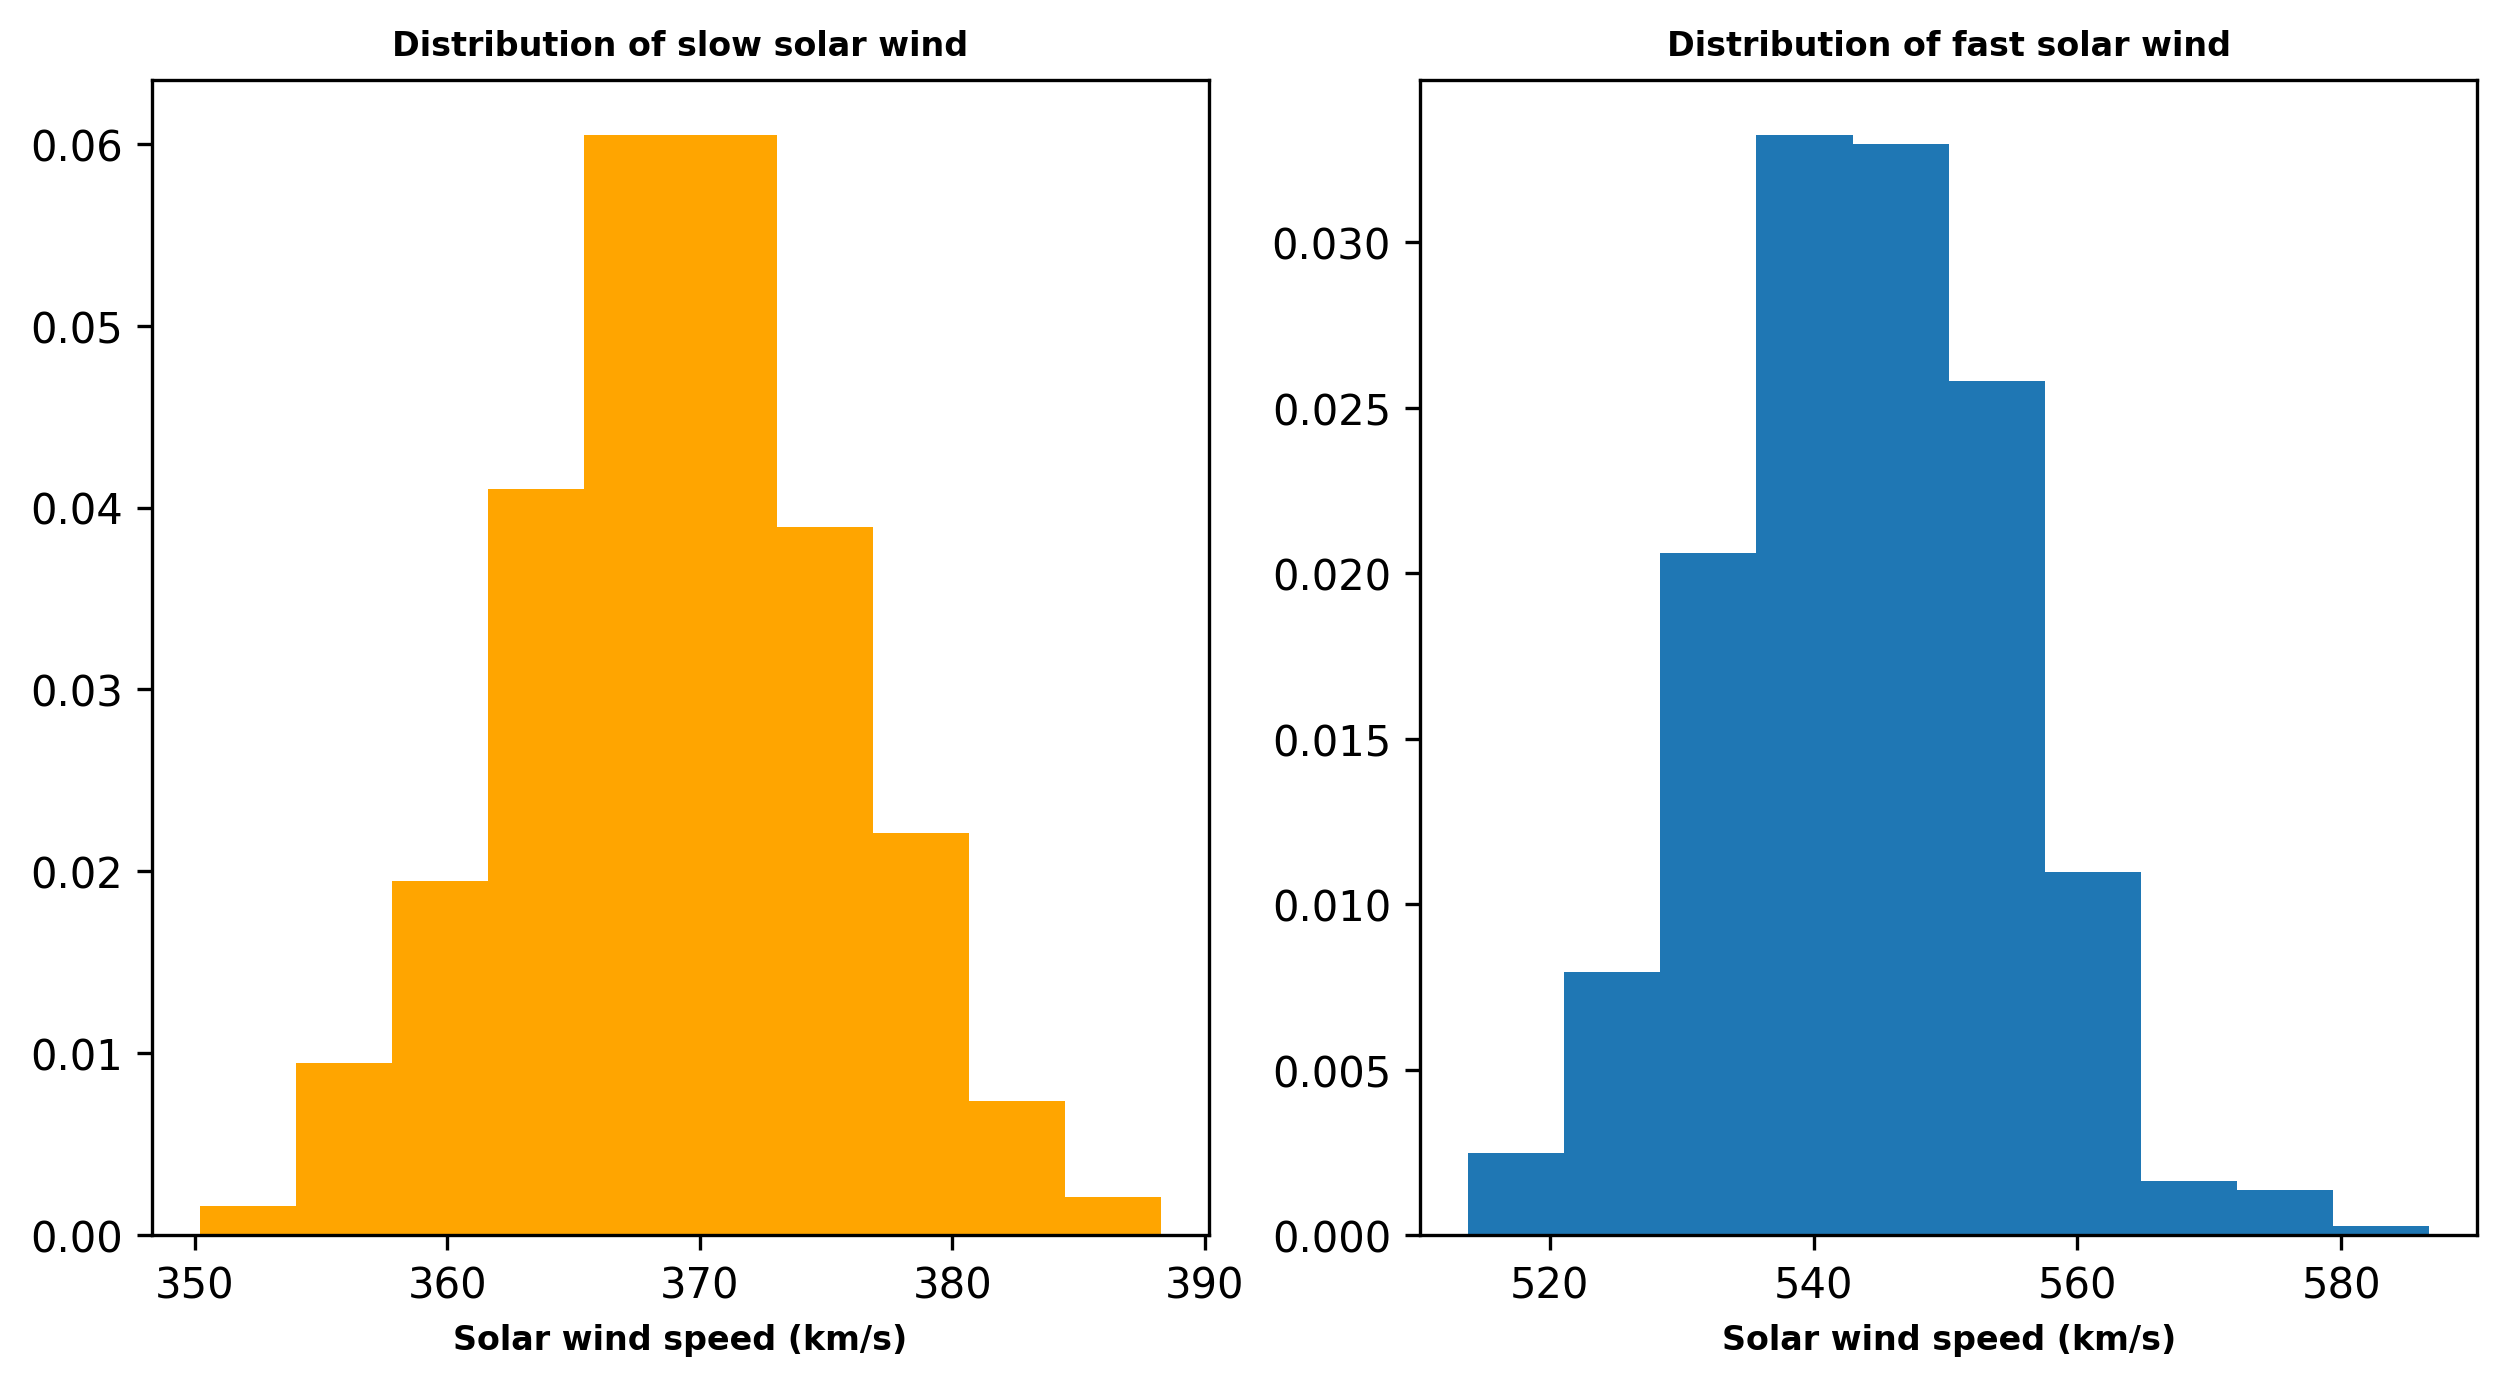

In [18]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows = 1, ncols=2, dpi = 300)

xbars_1 = [np.mean(np.random.choice(sw['Ur'][sw['Wind_Category'] == 'Slow'], size=50)) for _ in range(500)]
xbars_2 = [np.mean(np.random.choice(sw['Ur'][sw['Wind_Category'] == 'Fast'], size=50)) for _ in range(500)]

ax1.hist(xbars_1,color='orange', density = True);
ax2.hist(xbars_2, density = True);
ax1.set_xlabel('Solar wind speed (km/s)',fontdict = {'weight': 'bold','size':8})
ax2.set_xlabel('Solar wind speed (km/s)',fontdict = {'weight': 'bold','size':8})
ax1.set_title('Distribution of slow solar wind',fontdict = {'weight': 'bold','size':8})
ax2.set_title('Distribution of fast solar wind',fontdict = {'weight': 'bold','size':8})

plt.show()

#### Working on the data for Kp index

In [19]:
## The function to read and clean the data frame for Kp index
def dataframe_cleaning(path):
    df = pd.read_csv(path, skiprows=3) ## read the csv file from the path
    
    data= df.set_index('Kp').iloc[2:39].drop(np.nan).fillna(0.0).replace({'.':0.0}).astype(float)

    ##Select and categorize the appropriate data
    G0 = pd.DataFrame(data.iloc[0:14].reset_index().drop(columns='Kp').sum(axis=0)).T
    G1 = pd.DataFrame(data.iloc[14:17].reset_index().drop(columns='Kp').sum(axis=0)).T
    G2 = pd.DataFrame(data.iloc[17:20].reset_index().drop(columns='Kp').sum(axis=0)).T
    G3 = pd.DataFrame(data.iloc[20:23].reset_index().drop(columns='Kp').sum(axis=0)).T
    G4 = pd.DataFrame(data.iloc[23:27].reset_index().drop(columns='Kp').sum(axis=0)).T
    G5 = pd.DataFrame(data.iloc[27:28].reset_index().drop(columns='Kp').sum(axis=0)).T
    
    dataframe = pd.concat([G0,G1,G2,G3,G4,G5]).T                 # Join the the resulting table 
    dataframe.columns = ['kp<5', 'G1', 'G2', 'G3', 'G4', 'G5']  # Label the columns
    
    return dataframe

#### Load bulk of kp data from year 1992 - 2022

In [20]:
path = "Data_collection/Data/Kp"
read_files=glob.glob(os.path.join(path,"*.csv"))
read_files.sort()
len(read_files)

32

In [21]:
Kp = [dataframe_cleaning(i) for i in read_files[0:31]]

In [22]:
K_index = pd.concat(Kp)

In [23]:
K_index.reset_index(drop=True, inplace=True)

In [24]:
K_index

,kp<5,G1,G2,G3,G4,G5
0,237.0,11.0,0.0,0.0,0.0,0.0
1,165.0,29.0,23.0,13.0,2.0,0.0
2,237.0,11.0,0.0,0.0,0.0,0.0
3,233.0,5.0,2.0,0.0,0.0,0.0
4,217.0,16.0,6.0,4.0,3.0,0.0
...,...,...,...,...,...,...
367,237.0,8.0,2.0,1.0,0.0,0.0
368,225.0,11.0,4.0,0.0,0.0,0.0
369,241.0,6.0,1.0,0.0,0.0,0.0
370,232.0,8.0,0.0,0.0,0.0,0.0


##### Pie chart for the solar wind density distribution from year 1992 to 2022 december

In [25]:
### Categorize the plasma density at 1au
sw.loc[(sw['Np'] >= 0.1) & (sw['Np'] < 7), 'Np_Category'] = 'low'
sw.loc[(sw['Np'] >= 7) & (sw['Np'] < 60), 'Np_Category'] = 'high'
sw.loc[sw['Np'] >= 60, 'Np_Category'] = 'extreme'

In [26]:
sw['Np_Category'].value_counts(dropna = False)

Np_Category
low        56975
high       25292
extreme     8317
Name: count, dtype: int64

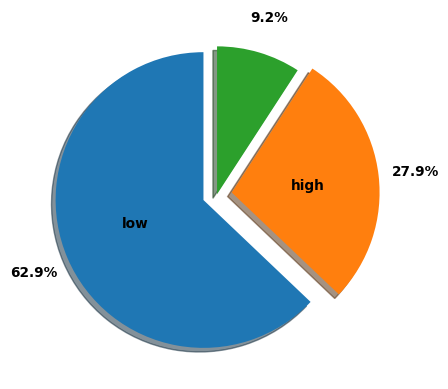

In [27]:
fig, ax = plt.subplots()

explode = (0.1, 0.1, 0)
labels = 'low', 'high', ''

ax.pie(sw['Np_Category'].value_counts(dropna = False), labels = labels, explode = explode,
       autopct='%1.1f%%',labeldistance=0.4,pctdistance=1.25, shadow= True, startangle=90,
      textprops={'size': 9.8,'fontweight' : 'bold'})


plt.show()

##### Pie chart for the solar wind magnetic field distribution from year 1992 to 2022 december

In [28]:
### Categorize the magnetic field at 1au
sw.loc[(sw['B'] >= 0.1) & (sw['B'] < 6.3), 'B_Category'] = 'low_B'
sw.loc[(sw['B'] >= 6.3) & (sw['B'] < 30), 'B_Category'] = 'high_B'
sw.loc[sw['B'] >= 30, 'B_Category'] = 'extreme'

In [29]:
sw['B_Category'].value_counts(dropna = False, normalize=True)

B_Category
low_B      0.642630
high_B     0.285326
extreme    0.072044
Name: proportion, dtype: float64

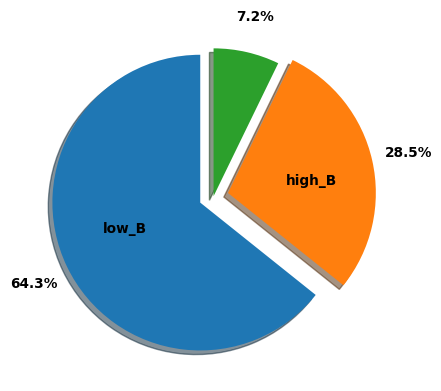

In [30]:
fig, ax = plt.subplots()

explode = (0.1, 0.1, 0)
labels = 'low_B', 'high_B', ''

ax.pie(sw['B_Category'].value_counts(dropna = False), labels = labels, explode = explode,
       autopct='%1.1f%%',labeldistance=0.4,pctdistance=1.25, shadow= True, startangle=90,
      textprops={'size': 9.8,'fontweight' : 'bold'})


plt.show()

##### Pie chart for the solar wind temperature at 1~au distribution from year 1992 to 2022 december

In [31]:
sw['T[K]'].describe()

count    9.058400e+04
mean     8.726592e+05
std      2.583303e+06
min      3.501667e+03
25%      3.930125e+04
50%      7.588567e+04
75%      1.528178e+05
max      1.000000e+07
Name: T[K], dtype: float64

In [32]:
### Categorize the magnetic field at 1au
sw.loc[(sw['T[K]'] >= 0) & (sw['T[K]'] < 110_000), 'T_Category'] = 'low_T'
sw.loc[(sw['T[K]'] >= 110_000) & (sw['T[K]'] < 1_000_000), 'T_Category'] = 'high_T'
sw.loc[sw['T[K]'] >= 1_000_000, 'T_Category'] = 'extreme'

In [33]:
sw['T_Category'].value_counts(dropna = False, normalize=True)

T_Category
low_T      0.642707
high_T     0.267520
extreme    0.089773
Name: proportion, dtype: float64

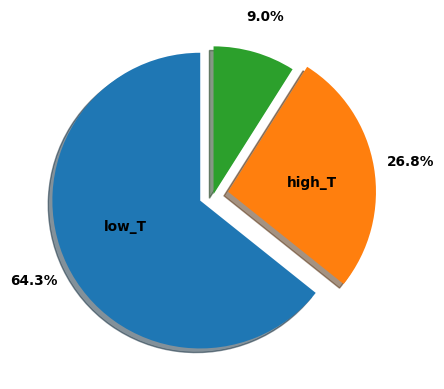

In [34]:
fig, ax = plt.subplots()

explode = (0.1, 0.1, 0)
labels = 'low_T', 'high_T', ''

ax.pie(sw['T_Category'].value_counts(dropna = False), labels = labels, explode = explode,
       autopct='%1.1f%%',labeldistance=0.4,pctdistance=1.25, shadow= True, startangle=90,
      textprops={'size': 9.8,'fontweight' : 'bold'})


plt.show()

In [35]:
sw.drop(columns = ['B','T[K]','Np','Ur'],inplace = True)

In [36]:
sw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90584 entries, 1992-01-01 00:00:00+00:00 to 2022-12-31 21:00:00+00:00
Freq: 3H
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Wind_Category  90584 non-null  object
 1   Np_Category    90584 non-null  object
 2   B_Category     90584 non-null  object
 3   T_Category     90584 non-null  object
dtypes: object(4)
memory usage: 3.5+ MB


<Axes: xlabel='Wind_Category'>

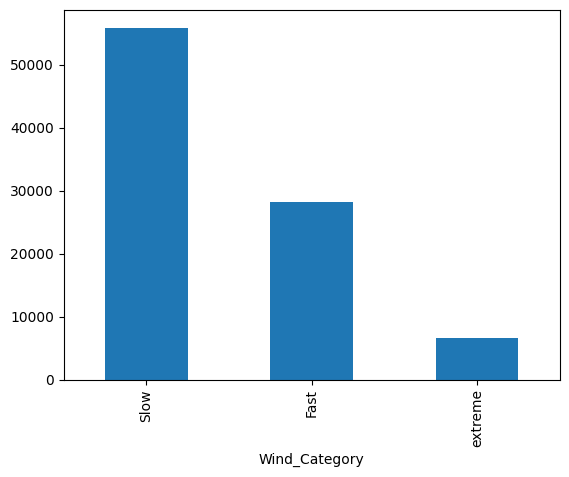

In [37]:
sw['Wind_Category'].value_counts().plot(kind = 'bar')

#### Read the solar indicies and the geomagnatic indicies

In [38]:
df2 = pd.read_csv('Data_collection/Data/all_param.csv', )

In [39]:
df2.columns = ['YYY', 'MM', 'DD' , 'days' ,'days_m', 'Bsr','dB','Kp1', 'Kp2','Kp3','Kp4','Kp5','Kp6','Kp7','Kp8','ap1','ap2','ap3','ap4','ap5','ap6','ap7', 'ap8','Ap', 'SN', 'F10.7obs', 'F10.7adj' ,'D']

In [40]:
df2.head(3)

,YYY,MM,DD,days,days_m,Bsr,dB,Kp1,Kp2,Kp3,...,ap4,ap5,ap6,ap7,ap8,Ap,SN,F10.7obs,F10.7adj,D
0,1992,1,1,21915,21915.5,2164,1,2.667,2.000,2.667,...,9,9,22,7,15,12,186,248.5,240.3,2
1,1992,1,2,21916,21916.5,2164,2,4.667,4.333,3.667,...,48,9,15,7,6,22,190,260.2,251.6,2
2,1992,1,3,21917,21917.5,2164,3,3.000,3.000,2.333,...,22,15,9,22,22,16,234,279.6,270.4,2


In [41]:
df2.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11323 entries, 0 to 11322
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   YYY       11323 non-null  int64  
 1   MM        11323 non-null  int64  
 2   DD        11323 non-null  int64  
 3   days      11323 non-null  int64  
 4   days_m    11323 non-null  float64
 5   Bsr       11323 non-null  int64  
 6   dB        11323 non-null  int64  
 7   Kp1       11323 non-null  float64
 8   Kp2       11323 non-null  float64
 9   Kp3       11323 non-null  float64
 10  Kp4       11323 non-null  float64
 11  Kp5       11323 non-null  float64
 12  Kp6       11323 non-null  float64
 13  Kp7       11323 non-null  float64
 14  Kp8       11323 non-null  float64
 15  ap1       11323 non-null  int64  
 16  ap2       11323 non-null  int64  
 17  ap3       11323 non-null  int64  
 18  ap4       11323 non-null  int64  
 19  ap5       11323 non-null  int64  
 20  ap6       11323 non-null  in

In [42]:
### Replacing -1 as nan
df2.replace({-1:np.nan},inplace = True)

In [43]:
df2['Kp']= df2.loc[:,'Kp1' : 'Kp8'].mean(axis=1)

In [44]:
df2.head()

,YYY,MM,DD,days,days_m,Bsr,dB,Kp1,Kp2,Kp3,...,ap5,ap6,ap7,ap8,Ap,SN,F10.7obs,F10.7adj,D,Kp
0,1992,1,1,21915,21915.5,2164,1,2.667,2.000,2.667,...,9,22,7,15,12,186,248.5,240.3,2,2.583375
1,1992,1,2,21916,21916.5,2164,2,4.667,4.333,3.667,...,9,15,7,6,22,190,260.2,251.6,2,3.333375
2,1992,1,3,21917,21917.5,2164,3,3.000,3.000,2.333,...,15,9,22,22,16,234,279.6,270.4,2,3.083375
3,1992,1,4,21918,21918.5,2164,4,3.333,4.000,3.333,...,9,7,15,22,16,243,274.7,265.6,2,3.041625
4,1992,1,5,21919,21919.5,2164,5,3.333,3.000,2.333,...,9,18,15,7,12,242,266.5,257.7,2,2.708125


In [45]:
Kp_3hr = pd.DataFrame(df2.loc[:,'Kp1' : 'Kp8'].stack(), columns=['Kp'])

In [46]:
Kp_3hr.reset_index();

In [47]:
sw['Kp'] = Kp_3hr['Kp']

In [48]:
sw['Kp'] = np.array(Kp_3hr['Kp'])

In [49]:
ap_3hr = pd.DataFrame(df2.loc[:,'ap1' : 'ap8'].stack(), columns=['ap'])

In [50]:
sw['ap']= np.array(ap_3hr['ap'])

In [51]:
sw.head(6)

,Wind_Category,Np_Category,B_Category,T_Category,Kp,ap
date,,,,,,
1992-01-01 00:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12
1992-01-01 03:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7
1992-01-01 06:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12
1992-01-01 09:00:00+00:00,extreme,extreme,extreme,extreme,2.333,9
1992-01-01 12:00:00+00:00,extreme,extreme,high_B,extreme,2.333,9
1992-01-01 15:00:00+00:00,extreme,extreme,extreme,extreme,3.667,22


In [52]:
averages_kp = [sw['Kp'][i:i+8].mean() for i in range(0, len(sw['Kp']), 8)]

In [53]:
sw['Avg_Kp'] = np.repeat(averages_kp, 8)

In [54]:
averages_ap = [sw['ap'][i:i+8].mean() for i in range(0, len(sw['ap']), 8)]

In [55]:
sw['Avg_Ap'] = np.round(np.repeat(averages_ap, 8)).astype(int)

In [56]:
sw['SN'] = np.repeat(np.array(df2['SN']), 8)

In [57]:
sw['F10.7obs'] = np.repeat(np.array(df2['F10.7obs']), 8)

In [58]:
sw['F10.7adj'] = np.repeat(np.array(df2['F10.7adj']), 8)

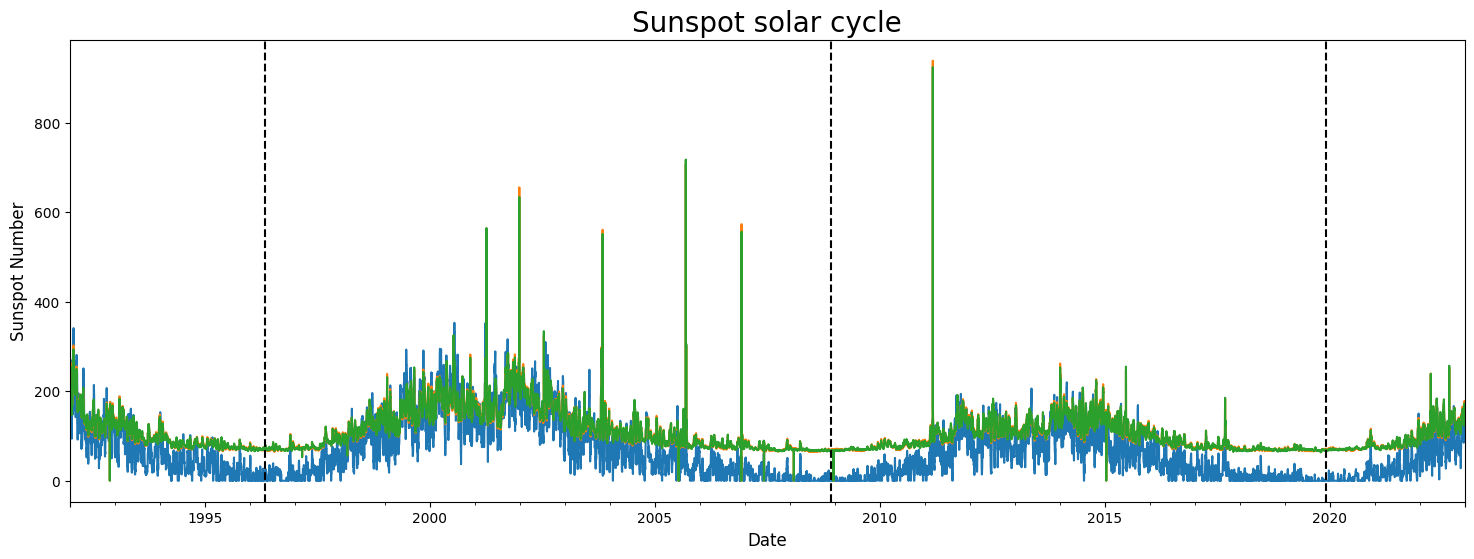

In [59]:
fig, ax = plt.subplots(figsize=(18, 6))  

sw['SN'].plot(ax=ax)
sw['F10.7obs'].plot(ax=ax)
sw['F10.7adj'].plot(ax=ax)


ax.set_xlabel("Date",fontdict= {'size': 12})
ax.set_ylabel("Sunspot Number",fontdict= {'size': 12})
ax.set_title("Sunspot solar cycle",fontdict= {'size': 20})

# Add vertical lines at specific dates
ax.axvline('1996-05', color='k', linestyle='--')
ax.axvline('2008-12', color='k', linestyle='--')
ax.axvline('2019-12', color='k', linestyle='--')

plt.show()

<Axes: xlabel='Wind_Category'>

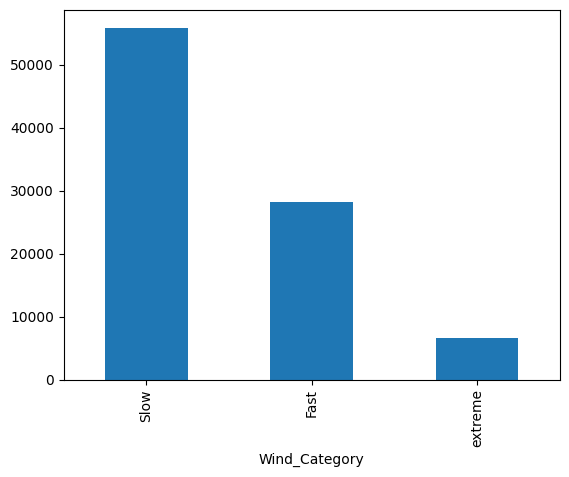

In [60]:
sw['Wind_Category'].value_counts().plot(kind = 'bar')

In [61]:
sw.head(10)

,Wind_Category,Np_Category,B_Category,T_Category,Kp,ap,Avg_Kp,Avg_Ap,SN,F10.7obs,F10.7adj
date,,,,,,,,,,,
1992-01-01 00:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3
1992-01-01 03:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3
1992-01-01 06:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3
1992-01-01 09:00:00+00:00,extreme,extreme,extreme,extreme,2.333,9,2.583375,12,186,248.5,240.3
1992-01-01 12:00:00+00:00,extreme,extreme,high_B,extreme,2.333,9,2.583375,12,186,248.5,240.3
1992-01-01 15:00:00+00:00,extreme,extreme,extreme,extreme,3.667,22,2.583375,12,186,248.5,240.3
1992-01-01 18:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3
1992-01-01 21:00:00+00:00,extreme,extreme,extreme,extreme,3.000,15,2.583375,12,186,248.5,240.3
1992-01-02 00:00:00+00:00,extreme,extreme,extreme,extreme,4.667,39,3.333375,22,190,260.2,251.6


In [62]:
## Smooth the sunspot data
sw['smooth_sn'] = savgol_filter(sw['SN'],11951,1)

In [63]:
sw.head(10)

,Wind_Category,Np_Category,B_Category,T_Category,Kp,ap,Avg_Kp,Avg_Ap,SN,F10.7obs,F10.7adj,smooth_sn
date,,,,,,,,,,,,
1992-01-01 00:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3,141.784625
1992-01-01 03:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3,141.772371
1992-01-01 06:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3,141.760116
1992-01-01 09:00:00+00:00,extreme,extreme,extreme,extreme,2.333,9,2.583375,12,186,248.5,240.3,141.747862
1992-01-01 12:00:00+00:00,extreme,extreme,high_B,extreme,2.333,9,2.583375,12,186,248.5,240.3,141.735607
1992-01-01 15:00:00+00:00,extreme,extreme,extreme,extreme,3.667,22,2.583375,12,186,248.5,240.3,141.723353
1992-01-01 18:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3,141.711098
1992-01-01 21:00:00+00:00,extreme,extreme,extreme,extreme,3.000,15,2.583375,12,186,248.5,240.3,141.698844
1992-01-02 00:00:00+00:00,extreme,extreme,extreme,extreme,4.667,39,3.333375,22,190,260.2,251.6,141.686589


#### Identify the trend of the sunspot solar cycle

In [64]:
data = np.array(sw['smooth_sn'])

In [65]:
# Set the initial trend as declining
trend = ['declining']

# Start the range from 1
for i in range(1, len(sw['smooth_sn'])):
    if sw['smooth_sn'].iloc[i] > sw['smooth_sn'].iloc[i - 1]:
        trend.append('rising')
    else:
        trend.append('declining')

In [66]:
sw['trend']= trend

In [67]:
sw['trend'].value_counts(normalize=True)

trend
declining    0.54641
rising       0.45359
Name: proportion, dtype: float64

In [68]:
from scipy.signal import find_peaks

In [69]:
## Rename the data in the trend column as solar min for the period of '1995-06':'1997-02'
sw.loc['1995-06':'1997-02']['trend'].replace({'declining':'solar_min','rising':'solar_min'},inplace = True)

In [70]:
## Rename the data in the trend column as solar min for the period of '2008-02':'2009-11
sw.loc['2008-02':'2009-11']['trend'].replace({'declining':'solar_min','rising':'solar_min'},inplace = True)

In [71]:
sw.loc['2000-05':'2002-01']['trend'].replace({'declining':'solar_min','rising':'solar_max'},inplace = True)

In [72]:
sw.loc['2012-05':'2014-02']['trend'].replace({'declining':'solar_min','rising':'solar_max'},inplace = True)

In [73]:
sw['trend'].unique()

array(['declining', 'rising', 'solar_min', 'solar_max'], dtype=object)

<Axes: ylabel='trend'>

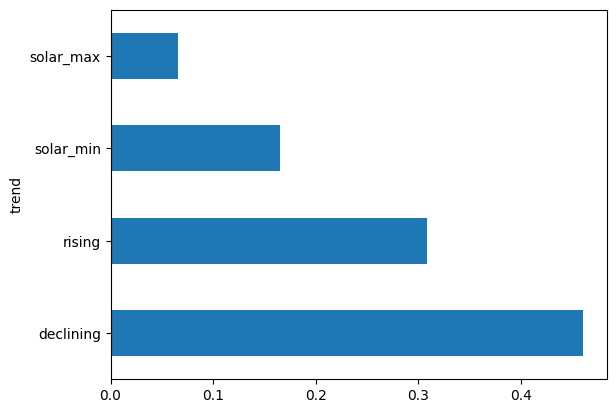

In [74]:
sw['trend'].value_counts(normalize=True).plot(kind = 'barh')

In [75]:
sw

,Wind_Category,Np_Category,B_Category,T_Category,Kp,ap,Avg_Kp,Avg_Ap,SN,F10.7obs,F10.7adj,smooth_sn,trend
date,,,,,,,,,,,,,
1992-01-01 00:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3,141.784625,declining
1992-01-01 03:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3,141.772371,declining
1992-01-01 06:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3,141.760116,declining
1992-01-01 09:00:00+00:00,extreme,extreme,extreme,extreme,2.333,9,2.583375,12,186,248.5,240.3,141.747862,declining
1992-01-01 12:00:00+00:00,extreme,extreme,high_B,extreme,2.333,9,2.583375,12,186,248.5,240.3,141.735607,declining
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 09:00:00+00:00,Fast,low,extreme,low_T,1.667,6,2.916750,15,98,164.9,159.5,82.147581,rising
2022-12-31 12:00:00+00:00,Fast,low,extreme,high_T,3.000,15,2.916750,15,98,164.9,159.5,82.156203,rising
2022-12-31 15:00:00+00:00,Fast,low,extreme,high_T,2.667,12,2.916750,15,98,164.9,159.5,82.164824,rising


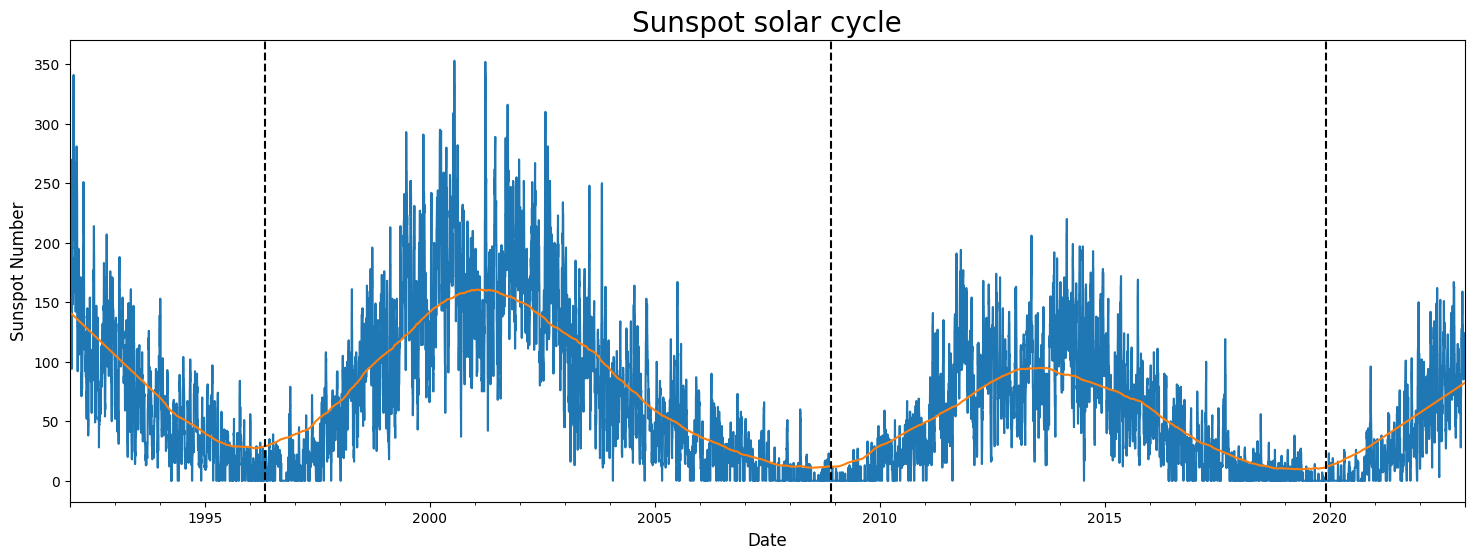

In [76]:
fig, ax = plt.subplots(figsize=(18, 6))  

sw['SN'].plot(ax=ax)
sw['smooth_sn'].plot(ax=ax)

ax.set_xlabel("Date",fontdict= {'size': 12})
ax.set_ylabel("Sunspot Number",fontdict= {'size': 12})
ax.set_title("Sunspot solar cycle",fontdict= {'size': 20})

# Add vertical lines at specific dates
ax.axvline('1996-05', color='k', linestyle='--')
ax.axvline('2008-12', color='k', linestyle='--')
ax.axvline('2019-12', color='k', linestyle='--')

plt.show()

In [77]:
sw.isna().sum()

Wind_Category     0
Np_Category       0
B_Category        0
T_Category        0
Kp                0
ap                0
Avg_Kp            0
Avg_Ap            0
SN                0
F10.7obs         64
F10.7adj         64
smooth_sn         0
trend             0
dtype: int64

In [78]:
sw.dropna(inplace = True)

In [79]:
#sw_dum = pd.get_dummies(sw, columns = ['Wind_Category','Np_Category','B_Category','T_Category'])

In [80]:
sw.columns

Index(['Wind_Category', 'Np_Category', 'B_Category', 'T_Category', 'Kp', 'ap',
       'Avg_Kp', 'Avg_Ap', 'SN', 'F10.7obs', 'F10.7adj', 'smooth_sn', 'trend'],
      dtype='object')

In [81]:
sw_dummify = pd.get_dummies(sw, columns = ['Wind_Category', 'Np_Category', 'B_Category', 'T_Category','trend'])

In [82]:
sw_dummify.head(3)

,Kp,ap,Avg_Kp,Avg_Ap,SN,F10.7obs,F10.7adj,smooth_sn,Wind_Category_Fast,Wind_Category_Slow,...,B_Category_extreme,B_Category_high_B,B_Category_low_B,T_Category_extreme,T_Category_high_T,T_Category_low_T,trend_declining,trend_rising,trend_solar_max,trend_solar_min
date,,,,,,,,,,,,,,,,,,,,,
1992-01-01 00:00:00+00:00,2.667,12,2.583375,12,186,248.5,240.3,141.784625,False,False,...,True,False,False,True,False,False,True,False,False,False
1992-01-01 03:00:00+00:00,2.000,7,2.583375,12,186,248.5,240.3,141.772371,False,False,...,True,False,False,True,False,False,True,False,False,False
1992-01-01 06:00:00+00:00,2.667,12,2.583375,12,186,248.5,240.3,141.760116,False,False,...,True,False,False,True,False,False,True,False,False,False


In [83]:
###### Lets cataegorized the Kp values 

In [140]:
### Categorize the Kp index to the G_scale
sw_dummify.loc[(sw_dummify['Kp'] >= 0) & (sw_dummify['Kp'] <= 4.33), 'G'] = 'G0'
sw_dummify.loc[(sw_dummify['Kp'] >4.33) & (sw_dummify['Kp'] <= 5.33), 'G'] = 'G1'
sw_dummify.loc[(sw_dummify['Kp'] >5.33) & (sw_dummify['Kp'] <= 6.33), 'G'] = 'G2'
sw_dummify.loc[(sw_dummify['Kp'] >6.33) & (sw_dummify['Kp'] <= 7.33), 'G'] = 'G3'
sw_dummify.loc[(sw_dummify['Kp'] >7.33) & (sw_dummify['Kp'] <= 8.67), 'G'] = 'G4'
sw_dummify.loc[(sw_dummify['Kp'] >8.67) & (sw_dummify['Kp'] <= 9.00), 'G'] = 'G5'

In [125]:
sw_dummify

,Kp,ap,Avg_Kp,Avg_Ap,SN,F10.7obs,F10.7adj,smooth_sn,Wind_Category_Fast,Wind_Category_Slow,...,B_Category_high_B,B_Category_low_B,T_Category_extreme,T_Category_high_T,T_Category_low_T,trend_declining,trend_rising,trend_solar_max,trend_solar_min,G
date,,,,,,,,,,,,,,,,,,,,,
1992-01-01 00:00:00+00:00,2.667,12,2.583375,12,186,248.5,240.3,141.784625,False,False,...,False,False,True,False,False,True,False,False,False,G0
1992-01-01 03:00:00+00:00,2.000,7,2.583375,12,186,248.5,240.3,141.772371,False,False,...,False,False,True,False,False,True,False,False,False,G0
1992-01-01 06:00:00+00:00,2.667,12,2.583375,12,186,248.5,240.3,141.760116,False,False,...,False,False,True,False,False,True,False,False,False,G0
1992-01-01 09:00:00+00:00,2.333,9,2.583375,12,186,248.5,240.3,141.747862,False,False,...,False,False,True,False,False,True,False,False,False,G0
1992-01-01 12:00:00+00:00,2.333,9,2.583375,12,186,248.5,240.3,141.735607,False,False,...,True,False,True,False,False,True,False,False,False,G0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 09:00:00+00:00,1.667,6,2.916750,15,98,164.9,159.5,82.147581,True,False,...,False,False,False,False,True,False,True,False,False,G0
2022-12-31 12:00:00+00:00,3.000,15,2.916750,15,98,164.9,159.5,82.156203,True,False,...,False,False,False,True,False,False,True,False,False,G0
2022-12-31 15:00:00+00:00,2.667,12,2.916750,15,98,164.9,159.5,82.164824,True,False,...,False,False,False,True,False,False,True,False,False,G0


#### Define the X,y variables

In [126]:
X = sw_dummify.drop(columns = ['Kp','Avg_Kp','G','ap','Avg_Ap'])
y = sw_dummify['G']

In [127]:
X.columns  ## Training features

Index(['SN', 'F10.7obs', 'F10.7adj', 'smooth_sn', 'Wind_Category_Fast',
       'Wind_Category_Slow', 'Wind_Category_extreme', 'Np_Category_extreme',
       'Np_Category_high', 'Np_Category_low', 'B_Category_extreme',
       'B_Category_high_B', 'B_Category_low_B', 'T_Category_extreme',
       'T_Category_high_T', 'T_Category_low_T', 'trend_declining',
       'trend_rising', 'trend_solar_max', 'trend_solar_min'],
      dtype='object')

In [129]:
y.value_counts(normalize=True)

G
G0    0.935605
G1    0.043449
G2    0.014428
G3    0.004474
G4    0.002000
G5    0.000044
Name: proportion, dtype: float64

In [130]:
### Train test split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, stratify=y) 

In [131]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.svm import SVC, SVR
from sklearn.ensemble import GradientBoostingClassifier

In [132]:
dt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

In [133]:
dt.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [134]:
dt.score(X_train,y_train)

0.9349683311238769

In [135]:
dt.score(X_test,y_test)

0.9350419796730004

In [136]:
preds = dt.predict(X_test)

In [137]:
preds

array(['G0', 'G0', 'G0', ..., 'G0', 'G0', 'G0'], dtype=object)

In [138]:
y_test

date
2004-05-29 06:00:00+00:00    G0
2022-07-24 12:00:00+00:00    G0
2010-10-31 00:00:00+00:00    G0
2009-05-29 21:00:00+00:00    G0
2014-10-31 06:00:00+00:00    G0
                             ..
1996-07-12 15:00:00+00:00    G0
2010-10-11 06:00:00+00:00    G0
2013-12-15 00:00:00+00:00    G0
2003-11-06 06:00:00+00:00    G0
2003-11-28 21:00:00+00:00    G0
Name: G, Length: 22630, dtype: object

In [139]:
### Testing the model

In [374]:
df_1 = pd.read_csv('Data_collection/Data/sunspot.csv', skiprows=None, header=None)
sn = df_1.iloc[:,0:7]

In [375]:
##Function to convert the time to gregorian date
def to_gregorian_date(year,month,day):
    Date = []
    for i,j,k in zip(year,month,day):
        date = datetime(i,j,k)
        gregorian_date = date.strftime('%Y-%m-%d %H:%M:%S')
        Date.append(gregorian_date)
    return Date    

In [376]:
sn['Date']=to_gregorian_date(sn[0],sn[1],sn[2])
sn.head(2)

,0,1,2,3,4,5,6,Date
0,1992,1,1,1992.001,186,0,186,1992-01-01 00:00:00
1,1992,1,2,1992.004,190,18,172,1992-01-02 00:00:00


In [377]:
##Convert the date column to a datetime data type
sn['date'] = pd.to_datetime(sn['Date'])

In [378]:
## Convert the date column as the index and convert the time to UTC format
sn.index = sn['date']
sn.index = sn.index.tz_localize('UTC')

In [379]:
sn.head(3)

,0,1,2,3,4,5,6,Date,date
date,,,,,,,,,
1992-01-01 00:00:00+00:00,1992,1,1,1992.001,186,0,186,1992-01-01 00:00:00,1992-01-01
1992-01-02 00:00:00+00:00,1992,1,2,1992.004,190,18,172,1992-01-02 00:00:00,1992-01-02
1992-01-03 00:00:00+00:00,1992,1,3,1992.007,234,26,208,1992-01-03 00:00:00,1992-01-03


In [380]:
# Only select the total sunspot number and the north , south sunspot number column
SN = sn.iloc[:,4:7]

In [381]:
## Rename the columns
SN.columns = ['total sunspots','north number', 'south number']

In [382]:
SN.head(4) ## Display the daily sunspot number from 1992-01-01

,total sunspots,north number,south number
date,,,
1992-01-01 00:00:00+00:00,186,0,186
1992-01-02 00:00:00+00:00,190,18,172
1992-01-03 00:00:00+00:00,234,26,208
1992-01-04 00:00:00+00:00,243,54,189


In [383]:
# Check for nulls
SN.isna().sum()

total sunspots    0
north number      0
south number      0
dtype: int64

In [384]:
# Check for nunique
SN.nunique()

total sunspots    308
north number      201
south number      200
dtype: int64

In [385]:
SN.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11596 entries, 1992-01-01 00:00:00+00:00 to 2023-09-30 00:00:00+00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   total sunspots  11596 non-null  int64
 1   north number    11596 non-null  int64
 2   south number    11596 non-null  int64
dtypes: int64(3)
memory usage: 362.4 KB


In [386]:
min(SN['total sunspots'])

0

In [387]:
#arima = SN.loc['1992-01':'2022-12']

#### Plot the Sunspot solar cycle

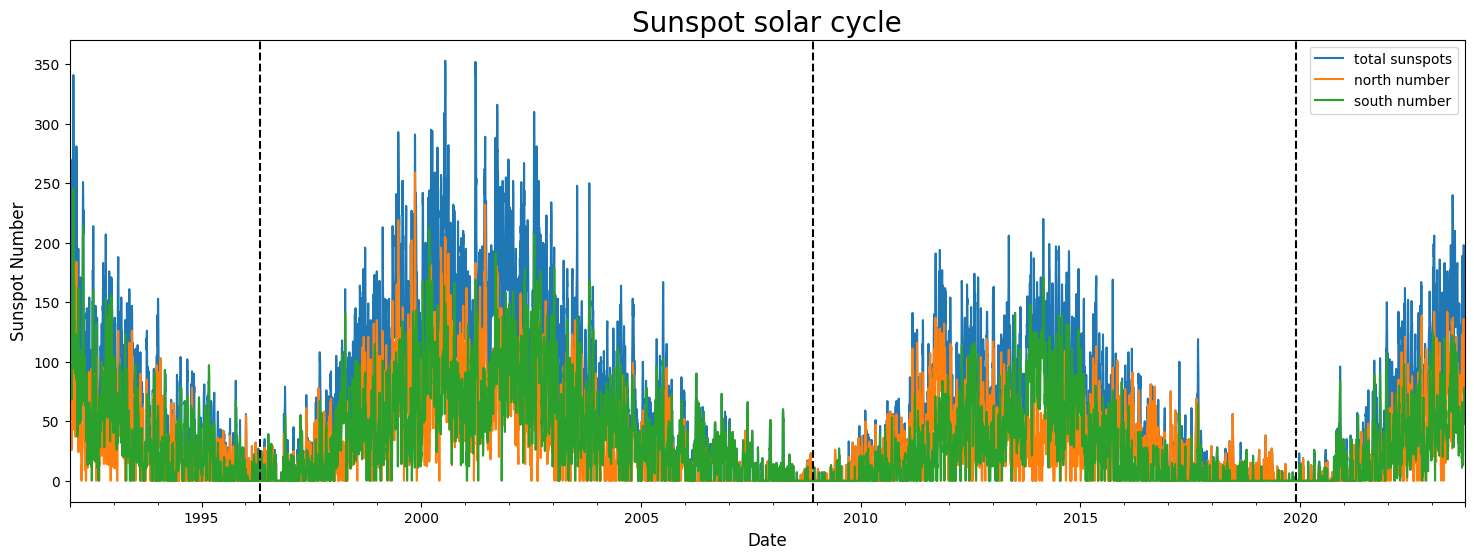

In [388]:
fig, ax = plt.subplots(figsize=(18, 6))  

SN.plot(ax=ax)

ax.set_xlabel("Date",fontdict= {'size': 12})
ax.set_ylabel("Sunspot Number",fontdict= {'size': 12})
ax.set_title("Sunspot solar cycle",fontdict= {'size': 20})

# Add vertical lines at specific dates
ax.axvline('1996-05', color='k', linestyle='--')
ax.axvline('2008-12', color='k', linestyle='--')
ax.axvline('2019-12', color='k', linestyle='--')

plt.show()

In [391]:
SN = SN.loc['1999-01':'1999-01']

In [ ]:
SN = SN.resample('M').mean()

In [395]:
SN['total sunspots']

date
1999-01-01 00:00:00+00:00     89
1999-01-02 00:00:00+00:00     94
1999-01-03 00:00:00+00:00     80
1999-01-04 00:00:00+00:00     90
1999-01-05 00:00:00+00:00     89
1999-01-06 00:00:00+00:00     67
1999-01-07 00:00:00+00:00     89
1999-01-08 00:00:00+00:00     71
1999-01-09 00:00:00+00:00     65
1999-01-10 00:00:00+00:00     64
1999-01-11 00:00:00+00:00     44
1999-01-12 00:00:00+00:00     49
1999-01-13 00:00:00+00:00     57
1999-01-14 00:00:00+00:00     90
1999-01-15 00:00:00+00:00    115
1999-01-16 00:00:00+00:00    115
1999-01-17 00:00:00+00:00    129
1999-01-18 00:00:00+00:00    141
1999-01-19 00:00:00+00:00    168
1999-01-20 00:00:00+00:00    166
1999-01-21 00:00:00+00:00    158
1999-01-22 00:00:00+00:00    150
1999-01-23 00:00:00+00:00    121
1999-01-24 00:00:00+00:00     94
1999-01-25 00:00:00+00:00     43
1999-01-26 00:00:00+00:00     42
1999-01-27 00:00:00+00:00     39
1999-01-28 00:00:00+00:00     39
1999-01-29 00:00:00+00:00     33
1999-01-30 00:00:00+00:00     33
1999-

In [ ]:
SN.reset_index(inplace = True ,drop = False)

In [ ]:
SN

In [ ]:
K_index

In [ ]:
all= SN.merge(K_index,left_index=True,right_index=True)

In [ ]:
all.set_index('date', drop=True, inplace = True)

In [ ]:
all

In [ ]:
filtered_data = all[all['total sunspots'] < 20]

filtered_data.head(2)

In [ ]:
filtered_data['kp<5'].unique()

In [ ]:
trend = []

for i in range(0, len(all)):
    if all['total sunspots'].iloc[i] > all['total sunspots'].iloc[i - 1]:
        upward_trend.append('rising')
    else:
        upward_trend.append('declining')

In [ ]:
all['upward_trend'] = upward_trend

In [ ]:
# Identify peaks (maximum values)
peaks = (all['total sunspots'] > all['total sunspots'].shift(1)) & (all['total sunspots'] > all['total sunspots'].shift(-1))

# Identify minimum values
minima = (all['total sunspots'] < all['total sunspots'].shift(1)) & (all['total sunspots'] < all['total sunspots'].shift(-1))

# Add 'peaks' and 'minima' as new columns to the DataFrame
all['peaks'] = peaks
all['minima'] = minima


In [ ]:
all['minimum'] = all['total sunspots'] < 10


In [ ]:
all = pd.get_dummies(all, columns = ['upward_trend', 'peaks','minima','minimum','total sunspots','north number','south number'])

In [ ]:
all

In [ ]:
X = all.drop(columns = ['kp<5','G1','G2','G3','G4','G5'])
y= all.iloc[:,0:6]

In [ ]:
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25) 

In [ ]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

In [ ]:
dt = RandomForestRegressor()

In [ ]:
dt.fit(X_train_ss, y_train)

In [ ]:
dt.score(X_train_ss, y_train)

In [ ]:
dt.score(X_test_ss, y_test)

In [ ]:
preds = dt.predict(X_test_ss)
preds

In [ ]:
preds.astype(int)

In [ ]:
y_test

In [ ]:
plt.scatter(x,np.log(y))

In [ ]:
all['G5'].plot()

In [ ]:
## Function to test whether the series is stationary and the value for d
def find_d(data):
    d = 0    # Initialize d to 0
    
    while adfuller(data.dropna())[1] >= 0.05:
        data = data.diff().dropna()         # Differencing the data
        d += 1                              # Increment d
        
    print(f'Series is stationary, and d = {d}')

In [ ]:
find_d(SN['total sunspots'])

In [ ]:
plot_acf(SN['total sunspots'].dropna(),lags = 700);

In [ ]:
plot_pacf(SN['total sunspots'].dropna(),lags = 10);

In [ ]:
# Create train-test split.
X_train, X_test, y_train, y_test = train_test_split(SN['total sunspots'],
                                                    SN['total sunspots'],
                                                    test_size = 0.3,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!

In [ ]:
import warnings
# Set to ignore any warnings
warnings.filterwarnings('ignore')

In [ ]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (52, 0, 10)) 

In [ ]:
# Fit model.
arima = model.fit()

In [ ]:
y_test

In [ ]:
predictions = arima.predict(start = y_test.index[0], end = y_test.index[-1])

#### Plot the predictions

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))  

y_train.plot(ax=ax)
y_test.plot(ax=ax)
predictions.plot(ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel("Sunspot number")
ax.set_title("Solar cycle predictions")
#ax.legend(['B_{1au}','Arima_model']) 

plt.show()

In [ ]:
df_1 = pd.read_csv('Data_collection/Data/1992-2023.csv1',skiprows=0)

In [ ]:
##define the columns
df_1.columns = ['date', 'B','T[K]','Np','Ur']

In [ ]:
df_1['date']=pd.to_datetime(df_1['date'])

In [ ]:
df_1.set_index('date' , inplace = True)

In [ ]:
OMNI = df_1.resample('D').mean()

In [ ]:
OMNI.head()

In [ ]:
B = []
for i in OMNI['B']:
    if i > 30:
        B.append(np.nan)
    else:
        B.append(i)

In [ ]:
OMNI['B']=B

In [ ]:
OMNI['B'].plot();

In [ ]:
U= []
for i in OMNI['Ur']:
    if i > 1000:
        U.append(np.nan)
    else:
        U.append(i)

In [ ]:
OMNI['Ur'] = U

In [ ]:
OMNI['Ur'].plot();

In [ ]:
N= []
for i in OMNI['Np']:
    if i > 30:
        N.append(np.nan)
    else:
        N.append(i)

In [ ]:
OMNI['Np'] = N

In [ ]:
OMNI['Np'].plot();

In [ ]:
T= []
for i in OMNI['T[K]']:
    if i > 0.500000e+06:
        T.append(np.nan)
    else:
        T.append(i)

In [ ]:
OMNI['T[K]'] = T

In [ ]:
OMNI['T[K]'].plot()

In [ ]:
arima.dropna()

In [ ]:
arima

In [ ]:
#arima.plot()

In [ ]:
arima.index = arima.index.tz_localize('UTC')

In [ ]:
arima

In [ ]:
OMNI;

In [ ]:
New = OMNI.merge(arima, left_index=True, right_index=True, how='inner')

In [ ]:
#New.dropna(inplace = True)

In [ ]:
New

In [ ]:
New.info()

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [ ]:
interpret_dftest(adfuller(New['B'].dropna()))

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Generate plot.
plot_acf(New['B'].dropna(),lags = 800);

In [ ]:
# Generate plot.
plot_pacf(New['B'].dropna(),lags = 30);

In [ ]:
# Create train-test split.
X_train, X_test, y_train, y_test = train_test_split(New.drop(columns=['B','T[K]','Np','Ur']),New['B'], train_size= 0.70,test_size=0.30, shuffle = False) 

In [ ]:
#New.drop(columns=['B','T[K]','Np','Ur']

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model = ARIMA(endog=y_train.astype(float),order = (52, 0, 28))

In [ ]:
# Fit model.
arima_2_0_1 = model.fit()

In [ ]:
y_train

In [ ]:
y_test

In [ ]:
preds = arima_2_0_1.predict(start = y_test.index[0], end = y_test.index[-1])

In [ ]:
y_test.index[0]

In [ ]:
preds

## Plot the time series plot

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))  


y_train.plot(ax=ax)
#y_test.plot(ax=ax)
preds.plot(ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel("Magnetic field [B]")
ax.set_title("Magnetic Field")
ax.legend(['B_{1au}','Arima_model']) 

plt.show()

In [ ]:
preds[-60:-1]

In [ ]:
from sklearn.linear_model import LinearRegression,LassoCV ,RidgeCV

In [ ]:
# Instantiate and fit the model
lr = RidgeCV()
lr.fit(X_train, y_train)

In [ ]:
# Evaluate R2 for train and test
lr.score(X_train, y_train), lr.score(X_test, y_test)

In [ ]:
# Generate predicted test values.
pred = lr.predict(X_test)

In [ ]:
pred

In [ ]:
# Let's plot our predictions! 
plt.figure(figsize=(10,6))

plt.plot(y_train, label ='y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(np.array(y_test.index), pred, label = 'preds')
plt.legend();